<a href="https://colab.research.google.com/github/CGarcia8CG/Projects/blob/main/Ecobici_PageRank_Dec_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas
!pip install keplergl folium

## Imports


In [ ]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from keplergl import KeplerGl
import folium
import pandas as pd

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

## Example

PageRank ponderado:
Nodo 1: 0.2850
Nodo 2: 0.1816
Nodo 3: 0.1096
Nodo 4: 0.4238


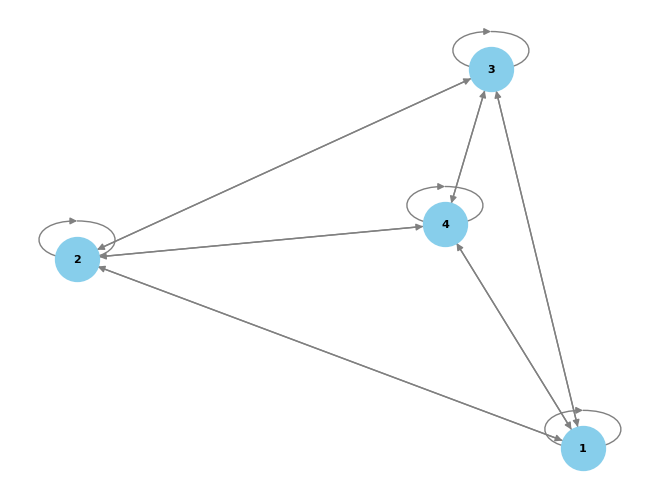

In [ ]:
# DataFrame con estaciones (nodos)
estaciones_data = {'ID': [1, 2, 3, 4],
                   'Nombre': ['Estacion A', 'Estacion B', 'Estacion C', 'Estacion D'],
                   'geometry': [Point(-74.0, 39.7), Point(-75.1, 40.8), Point(-74.2, 41.9), Point(-74.3, 41.0)]}

estaciones_gdf = gpd.GeoDataFrame(estaciones_data, geometry='geometry', crs='EPSG:4326')

# DataFrame con matriz origen-destino y pesos
matriz_data = {'1': [0, 10, 5, 0],
               '2': [0, 0, 0, 2],
               '3': [0, 0, 0, 1],
               '4': [3, 0, 0, 2]}

matriz_df = pd.DataFrame(matriz_data, index=['1', '2', '3', '4'])

# Crear un grafo dirigido
G = nx.DiGraph()

# Agregar nodos al grafo desde el DataFrame de estaciones
for _, estacion in estaciones_gdf.iterrows():
    G.add_node(estacion['ID'], nombre=estacion['Nombre'], geometry=estacion['geometry'])

# Agregar arcos ponderados al grafo desde el DataFrame de matriz origen-destino
for origen, destinos_pesos in matriz_df.iterrows():
    for destino, peso in destinos_pesos.items():
      #print(peso)
      G.add_edge(int(origen), int(destino), weight=peso)
       # if peso > 0: ### Para evitar la diagonal principal
         #   G.add_edge(int(origen), int(destino), weight=peso)

# Calcular PageRank ponderado
weighted_pagerank = nx.pagerank(G, weight='weight')

# Mostrar resultados
print("PageRank ponderado:")
for node, value in weighted_pagerank.items():
    print(f"Nodo {node}: {value:.4f}")

# Visualizar la red
posiciones = {node: (data['geometry'].x, data['geometry'].y) for node, data in G.nodes(data=True)}
nx.draw(G, posiciones, with_labels=True, font_weight='bold', node_size=1000, node_color='skyblue', font_color='black', font_size=8, edge_color='gray')
plt.show()

In [ ]:
# Crear un mapa de Folium centrado en la primera estación
m = folium.Map(location=[estaciones_gdf['geometry'].iloc[0].y, estaciones_gdf['geometry'].iloc[0].x], zoom_start=13)

# Añadir círculos a la capa del mapa con tamaños basados en el PageRank
for node, data in G.nodes(data=True):
    pagerank_value = weighted_pagerank[node]
    folium.CircleMarker(
        location=[data['geometry'].y, data['geometry'].x],
        radius=pagerank_value * 100,  # Puedes ajustar el factor de escala según sea necesario
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Estacion {node} - PageRank: {pagerank_value:.4f}"
    ).add_to(m)

# Añadir PoliLíneas a la capa del mapa
for origen, destinos_pesos in matriz_df.iterrows():
    for destino, peso in destinos_pesos.items():
        if peso > 0:
            coords = [estaciones_gdf.loc[estaciones_gdf['ID'] == int(origen)]['geometry'].iloc[0].coords[0],
                      estaciones_gdf.loc[estaciones_gdf['ID'] == int(destino)]['geometry'].iloc[0].coords[0]]
            folium.PolyLine(
                locations=[(coord[1], coord[0]) for coord in coords],
                color='red',
                weight=2,
                opacity=0.7,
                popup=f"Peso: {peso}"
            ).add_to(m)

# Mostrar el mapa
m
#m.save('pagerank_map.html')

In [ ]:
estaciones_gdf['lat'] = estaciones_gdf['geometry'].y
estaciones_gdf['lng'] = estaciones_gdf['geometry'].x

estaciones_gdf = gpd.GeoDataFrame(estaciones_gdf, geometry=gpd.GeoSeries([Point(geom) for geom in estaciones_gdf['geometry']]), crs='EPSG:4326')
# Display the updated DataFrame
estaciones_gdf

,ID,Nombre,geometry,lat,lng
0,1,Estacion A,POINT (-74.00000 39.70000),39.7,-74.0
1,2,Estacion B,POINT (-75.10000 40.80000),40.8,-75.1
2,3,Estacion C,POINT (-74.20000 41.90000),41.9,-74.2
3,4,Estacion D,POINT (-74.30000 41.00000),41.0,-74.3


In [ ]:
pagerank_series = pd.Series(weighted_pagerank, name='PageRank')
pagerank_series = pagerank_series.reset_index(drop=True)
pagerank_series

0    0.284989
1    0.181608
2    0.109554
3    0.423849
Name: PageRank, dtype: float64

In [ ]:
estaciones_gdf = pd.concat([estaciones_gdf, pagerank_series], axis=1, ignore_index=False)
estaciones_gdf

,ID,Nombre,geometry,lat,lng,PageRank
0,1,Estacion A,POINT (-74.00000 39.70000),39.7,-74.0,0.284989
1,2,Estacion B,POINT (-75.10000 40.80000),40.8,-75.1,0.181608
2,3,Estacion C,POINT (-74.20000 41.90000),41.9,-74.2,0.109554
3,4,Estacion D,POINT (-74.30000 41.00000),41.0,-74.3,0.423849


## EcoBici Code

### Origin-Destination Matrix

In [ ]:
df1 = pd.read_excel("datos_abiertos_2023_diciembre.xlsx",sheet_name="OD")
df1.head()

,Etiquetas de fila,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
0,1,128.0,52.0,6.0,101.0,67.0,49.0,68.0,15.0,57.0,...,1.0,2.0,1.0,21.0,36.0,5.0,2.0,4.0,4.0,6.0
1,2,65.0,68.0,4.0,10.0,18.0,29.0,23.0,8.0,24.0,...,NaN,5.0,NaN,21.0,6.0,1.0,2.0,1.0,NaN,2.0
2,3,8.0,2.0,27.0,8.0,5.0,8.0,22.0,6.0,10.0,...,4.0,NaN,3.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN
3,4,114.0,17.0,2.0,102.0,27.0,44.0,43.0,7.0,7.0,...,1.0,2.0,NaN,4.0,1.0,5.0,3.0,1.0,NaN,NaN
4,5,68.0,27.0,4.0,35.0,109.0,19.0,55.0,7.0,27.0,...,4.0,4.0,NaN,4.0,7.0,3.0,8.0,1.0,1.0,NaN


### Stations

In [ ]:
df2 = pd.read_excel("Estaciones ecobici.xlsx")
df2.head()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados
0,ECOBICI,1,Río Sena - Río Balsas,Río Sena,Río Balsas,Cuauhtémoc,CUAUHTEMOC,19.433590,-99.167819,4G,27
1,ECOBICI,2,Río Guadalquivir - Río Nazas,Río Guadalquivir,Río Nazas,Cuauhtémoc,CUAUHTEMOC,19.430510,-99.171201,3G,21
2,ECOBICI,3,Reforma - Insurgentes,Reforma,Insurgentes,Tabacalera,CUAUHTEMOC,19.431630,-99.158547,4G,36
3,ECOBICI,4,Río Nilo - Río Pánuco,Río Nilo,Río Pánuco,Cuauhtémoc,CUAUHTEMOC,19.428491,-99.171693,3G,15
4,ECOBICI,5,Río Pánuco - Río Tíber,Río Pánuco,Río Tíber,Cuauhtémoc,CUAUHTEMOC,19.429804,-99.169451,3G,12


In [ ]:
df1  = df1.fillna(0)
df1.head()

,Etiquetas de fila,1,2,3,4,5,6,7,8,9,...,471,472,473,474,475,476,477,478,479,480
0,1,128.0,52.0,6.0,101.0,67.0,49.0,68.0,15.0,57.0,...,1.0,2.0,1.0,21.0,36.0,5.0,2.0,4.0,4.0,6.0
1,2,65.0,68.0,4.0,10.0,18.0,29.0,23.0,8.0,24.0,...,0.0,5.0,0.0,21.0,6.0,1.0,2.0,1.0,0.0,2.0
2,3,8.0,2.0,27.0,8.0,5.0,8.0,22.0,6.0,10.0,...,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
3,4,114.0,17.0,2.0,102.0,27.0,44.0,43.0,7.0,7.0,...,1.0,2.0,0.0,4.0,1.0,5.0,3.0,1.0,0.0,0.0
4,5,68.0,27.0,4.0,35.0,109.0,19.0,55.0,7.0,27.0,...,4.0,4.0,0.0,4.0,7.0,3.0,8.0,1.0,1.0,0.0


In [ ]:
df1.set_index('Etiquetas de fila', inplace=True)
df1

,1,2,3,4,5,6,7,8,9,10,...,471,472,473,474,475,476,477,478,479,480
Etiquetas de fila,,,,,,,,,,,,,,,,,,,,,
1,128.0,52.0,6.0,101.0,67.0,49.0,68.0,15.0,57.0,24.0,...,1.0,2.0,1.0,21.0,36.0,5.0,2.0,4.0,4.0,6.0
2,65.0,68.0,4.0,10.0,18.0,29.0,23.0,8.0,24.0,12.0,...,0.0,5.0,0.0,21.0,6.0,1.0,2.0,1.0,0.0,2.0
3,8.0,2.0,27.0,8.0,5.0,8.0,22.0,6.0,10.0,15.0,...,4.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
4,114.0,17.0,2.0,102.0,27.0,44.0,43.0,7.0,7.0,6.0,...,1.0,2.0,0.0,4.0,1.0,5.0,3.0,1.0,0.0,0.0
5,68.0,27.0,4.0,35.0,109.0,19.0,55.0,7.0,27.0,5.0,...,4.0,4.0,0.0,4.0,7.0,3.0,8.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476,9.0,2.0,7.0,3.0,3.0,6.0,6.0,1.0,2.0,2.0,...,11.0,6.0,2.0,41.0,31.0,84.0,5.0,36.0,7.0,21.0
477,4.0,2.0,1.0,1.0,8.0,2.0,12.0,1.0,4.0,2.0,...,16.0,14.0,1.0,22.0,18.0,5.0,43.0,10.0,7.0,11.0
478,5.0,0.0,0.0,0.0,4.0,5.0,2.0,0.0,3.0,7.0,...,3.0,1.0,2.0,11.0,12.0,39.0,18.0,11.0,0.0,9.0


In [ ]:
geometry = [Point(xy) for xy in zip(df2['longitud'], df2['latitud'])]
gdf = gpd.GeoDataFrame(df2, geometry=geometry, crs='EPSG:4326')
gdf.head()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados,geometry
0,ECOBICI,1,Río Sena - Río Balsas,Río Sena,Río Balsas,Cuauhtémoc,CUAUHTEMOC,19.433590,-99.167819,4G,27,POINT (-99.16782 19.43359)
1,ECOBICI,2,Río Guadalquivir - Río Nazas,Río Guadalquivir,Río Nazas,Cuauhtémoc,CUAUHTEMOC,19.430510,-99.171201,3G,21,POINT (-99.17120 19.43051)
2,ECOBICI,3,Reforma - Insurgentes,Reforma,Insurgentes,Tabacalera,CUAUHTEMOC,19.431630,-99.158547,4G,36,POINT (-99.15855 19.43163)
3,ECOBICI,4,Río Nilo - Río Pánuco,Río Nilo,Río Pánuco,Cuauhtémoc,CUAUHTEMOC,19.428491,-99.171693,3G,15,POINT (-99.17169 19.42849)
4,ECOBICI,5,Río Pánuco - Río Tíber,Río Pánuco,Río Tíber,Cuauhtémoc,CUAUHTEMOC,19.429804,-99.169451,3G,12,POINT (-99.16945 19.42980)


In [ ]:
gdf["geometry"]

gdf = gpd.GeoDataFrame(gdf, geometry=gpd.GeoSeries([Point(geom) for geom in gdf['geometry']]), crs='EPSG:4326')
gdf["geometry"]

0      POINT (-99.16782 19.43359)
1      POINT (-99.17120 19.43051)
2      POINT (-99.15855 19.43163)
3      POINT (-99.17169 19.42849)
4      POINT (-99.16945 19.42980)
                  ...            
475    POINT (-99.18443 19.44213)
476    POINT (-99.18174 19.44091)
477    POINT (-99.17696 19.44082)
478    POINT (-99.17966 19.44443)
479    POINT (-99.18165 19.44607)
Name: geometry, Length: 480, dtype: geometry

In [ ]:
gdf["num_cicloestacion"]

0        1
1        2
2        3
3        4
4        5
      ... 
475    476
476    477
477    478
478    479
479    480
Name: num_cicloestacion, Length: 480, dtype: int64

In [ ]:
# Crear un grafo dirigido
G = nx.DiGraph()

In [ ]:
# Agregar nodos al grafo desde el DataFrame de estaciones
for _, estacion in gdf.iterrows():
    G.add_node(estacion['num_cicloestacion'], nombre=estacion['nombre'], geometry=estacion['geometry'])

In [ ]:
# Agregar arcos ponderados al grafo desde el DataFrame de matriz origen-destino
for origen, destinos_pesos in df1.iterrows():
    for destino, peso in destinos_pesos.items():
      #print(peso)
      #G.add_edge(int(origen), int(destino), weight=peso)
      if peso > 0: ### Para evitar la diagonal principal
        G.add_edge(int(origen), int(destino), weight=peso)

In [ ]:
# Calcular PageRank ponderado
weighted_pagerank = nx.pagerank(G, weight='weight')

In [ ]:
# Crear un mapa de Folium centrado en la primera estación
m = folium.Map(location=[gdf['geometry'].y.mean(), gdf['geometry'].x.mean()], zoom_start=12)
m

In [ ]:
gdf.head()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados,geometry
0,ECOBICI,1,Río Sena - Río Balsas,Río Sena,Río Balsas,Cuauhtémoc,CUAUHTEMOC,19.433590,-99.167819,4G,27,POINT (-99.16782 19.43359)
1,ECOBICI,2,Río Guadalquivir - Río Nazas,Río Guadalquivir,Río Nazas,Cuauhtémoc,CUAUHTEMOC,19.430510,-99.171201,3G,21,POINT (-99.17120 19.43051)
2,ECOBICI,3,Reforma - Insurgentes,Reforma,Insurgentes,Tabacalera,CUAUHTEMOC,19.431630,-99.158547,4G,36,POINT (-99.15855 19.43163)
3,ECOBICI,4,Río Nilo - Río Pánuco,Río Nilo,Río Pánuco,Cuauhtémoc,CUAUHTEMOC,19.428491,-99.171693,3G,15,POINT (-99.17169 19.42849)
4,ECOBICI,5,Río Pánuco - Río Tíber,Río Pánuco,Río Tíber,Cuauhtémoc,CUAUHTEMOC,19.429804,-99.169451,3G,12,POINT (-99.16945 19.42980)


In [ ]:
gdf['lat'] = gdf['geometry'].y
gdf['lng'] = gdf['geometry'].x

gdf = gpd.GeoDataFrame(gdf, geometry=gpd.GeoSeries([Point(geom) for geom in gdf['geometry']]), crs='EPSG:4326')
# Display the updated DataFrame
gdf.head()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados,geometry,lat,lng
0,ECOBICI,1,Río Sena - Río Balsas,Río Sena,Río Balsas,Cuauhtémoc,CUAUHTEMOC,19.433590,-99.167819,4G,27,POINT (-99.16782 19.43359),19.433590,-99.167819
1,ECOBICI,2,Río Guadalquivir - Río Nazas,Río Guadalquivir,Río Nazas,Cuauhtémoc,CUAUHTEMOC,19.430510,-99.171201,3G,21,POINT (-99.17120 19.43051),19.430510,-99.171201
2,ECOBICI,3,Reforma - Insurgentes,Reforma,Insurgentes,Tabacalera,CUAUHTEMOC,19.431630,-99.158547,4G,36,POINT (-99.15855 19.43163),19.431630,-99.158547
3,ECOBICI,4,Río Nilo - Río Pánuco,Río Nilo,Río Pánuco,Cuauhtémoc,CUAUHTEMOC,19.428491,-99.171693,3G,15,POINT (-99.17169 19.42849),19.428491,-99.171693
4,ECOBICI,5,Río Pánuco - Río Tíber,Río Pánuco,Río Tíber,Cuauhtémoc,CUAUHTEMOC,19.429804,-99.169451,3G,12,POINT (-99.16945 19.42980),19.429804,-99.169451


In [ ]:
pagerank_series = pd.Series(weighted_pagerank, name='PageRank')
pagerank_series = pagerank_series.reset_index(drop=True)
pagerank_series

0      0.005738
1      0.002471
2      0.001761
3      0.003055
4      0.003244
         ...   
475    0.001531
476    0.001081
477    0.000802
478    0.001594
479    0.001562
Name: PageRank, Length: 480, dtype: float64

In [ ]:
gdf = pd.concat([gdf, pagerank_series], axis=1, ignore_index=False)
gdf.head()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados,geometry,lat,lng,PageRank
0,ECOBICI,1,Río Sena - Río Balsas,Río Sena,Río Balsas,Cuauhtémoc,CUAUHTEMOC,19.433590,-99.167819,4G,27,POINT (-99.16782 19.43359),19.433590,-99.167819,0.005738
1,ECOBICI,2,Río Guadalquivir - Río Nazas,Río Guadalquivir,Río Nazas,Cuauhtémoc,CUAUHTEMOC,19.430510,-99.171201,3G,21,POINT (-99.17120 19.43051),19.430510,-99.171201,0.002471
2,ECOBICI,3,Reforma - Insurgentes,Reforma,Insurgentes,Tabacalera,CUAUHTEMOC,19.431630,-99.158547,4G,36,POINT (-99.15855 19.43163),19.431630,-99.158547,0.001761
3,ECOBICI,4,Río Nilo - Río Pánuco,Río Nilo,Río Pánuco,Cuauhtémoc,CUAUHTEMOC,19.428491,-99.171693,3G,15,POINT (-99.17169 19.42849),19.428491,-99.171693,0.003055
4,ECOBICI,5,Río Pánuco - Río Tíber,Río Pánuco,Río Tíber,Cuauhtémoc,CUAUHTEMOC,19.429804,-99.169451,3G,12,POINT (-99.16945 19.42980),19.429804,-99.169451,0.003244


In [ ]:
gdf.tail()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados,geometry,lat,lng,PageRank
475,ECOBICI,476,Lago Como - Laguna de Mayrán,Lago Como,Laguna de Mayrán,Granada,MIGUEL HIDALGO,19.442127,-99.184433,4G,36,POINT (-99.18443 19.44213),19.442127,-99.184433,0.001531
476,ECOBICI,477,Lago Iseo - Laguna de Mayrán,Lago Iseo,Laguna de Mayrán,Anáhuac I Sección,MIGUEL HIDALGO,19.440905,-99.181743,3G,24,POINT (-99.18174 19.44091),19.440905,-99.181743,0.001081
477,ECOBICI,478,Laguna de Mayrán - Lago Chalco,Laguna de Mayrán,Lago Chalco,Anáhuac I Sección,MIGUEL HIDALGO,19.440818,-99.176961,3G,27,POINT (-99.17696 19.44082),19.440818,-99.176961,0.000802
478,ECOBICI,479,Lago Muritz - Av. Marina Nacional,Lago Muritz,Av. Marina Nacional,Mariano Escobedo,MIGUEL HIDALGO,19.444433,-99.179664,Multimedial,24,POINT (-99.17966 19.44443),19.444433,-99.179664,0.001594
479,ECOBICI,480,Lago Iseo - Av. Marina Nacional,Lago Iseo,Av. Marina Nacional,Mariano Escobedo,MIGUEL HIDALGO,19.446073,-99.181654,3G,21,POINT (-99.18165 19.44607),19.446073,-99.181654,0.001562


In [ ]:
gdf["geometry"]

0      POINT (-99.16782 19.43359)
1      POINT (-99.17120 19.43051)
2      POINT (-99.15855 19.43163)
3      POINT (-99.17169 19.42849)
4      POINT (-99.16945 19.42980)
                  ...            
475    POINT (-99.18443 19.44213)
476    POINT (-99.18174 19.44091)
477    POINT (-99.17696 19.44082)
478    POINT (-99.17966 19.44443)
479    POINT (-99.18165 19.44607)
Name: geometry, Length: 480, dtype: geometry

In [ ]:
for idx, row in gdf.iterrows():
    pagerank_value = row['PageRank']
    folium.CircleMarker(
        location=[row['geometry'].y, row['geometry'].x],
        radius=pagerank_value * 2000,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        popup=f"Station {row['num_cicloestacion']} - Name {row['nombre']}  - PageRank: {pagerank_value:.4f}"
    ).add_to(m)

m

In [ ]:
gdf.head()

,sistema,num_cicloestacion,nombre,calle_principal,calle_secundaria,colonia,alcaldia,latitud,longitud,tipo_ce,candados,geometry,lat,lng,PageRank
0,ECOBICI,1,Río Sena - Río Balsas,Río Sena,Río Balsas,Cuauhtémoc,CUAUHTEMOC,19.433590,-99.167819,4G,27,POINT (-99.16782 19.43359),19.433590,-99.167819,0.005738
1,ECOBICI,2,Río Guadalquivir - Río Nazas,Río Guadalquivir,Río Nazas,Cuauhtémoc,CUAUHTEMOC,19.430510,-99.171201,3G,21,POINT (-99.17120 19.43051),19.430510,-99.171201,0.002471
2,ECOBICI,3,Reforma - Insurgentes,Reforma,Insurgentes,Tabacalera,CUAUHTEMOC,19.431630,-99.158547,4G,36,POINT (-99.15855 19.43163),19.431630,-99.158547,0.001761
3,ECOBICI,4,Río Nilo - Río Pánuco,Río Nilo,Río Pánuco,Cuauhtémoc,CUAUHTEMOC,19.428491,-99.171693,3G,15,POINT (-99.17169 19.42849),19.428491,-99.171693,0.003055
4,ECOBICI,5,Río Pánuco - Río Tíber,Río Pánuco,Río Tíber,Cuauhtémoc,CUAUHTEMOC,19.429804,-99.169451,3G,12,POINT (-99.16945 19.42980),19.429804,-99.169451,0.003244


In [ ]:
kepler_map = KeplerGl(height=600)
kepler_map.add_data(data=gdf, name='Estaciones')

# Añadir círculos a la capa del mapa con tamaños basados en el PageRank
for _, data in gdf.iterrows():
    kepler_map.add_data(data={'geometry': [data['geometry']], 'PageRank': [data['PageRank']]})

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [ ]:
kepler_map

KeplerGl(data={'Estaciones': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, …

In [ ]:
m.save('pagerank_map_folium.html')
kepler_map.save_to_html(file_name='pagerank_map_kepler.html')

Map saved to pagerank_map_kepler.html!


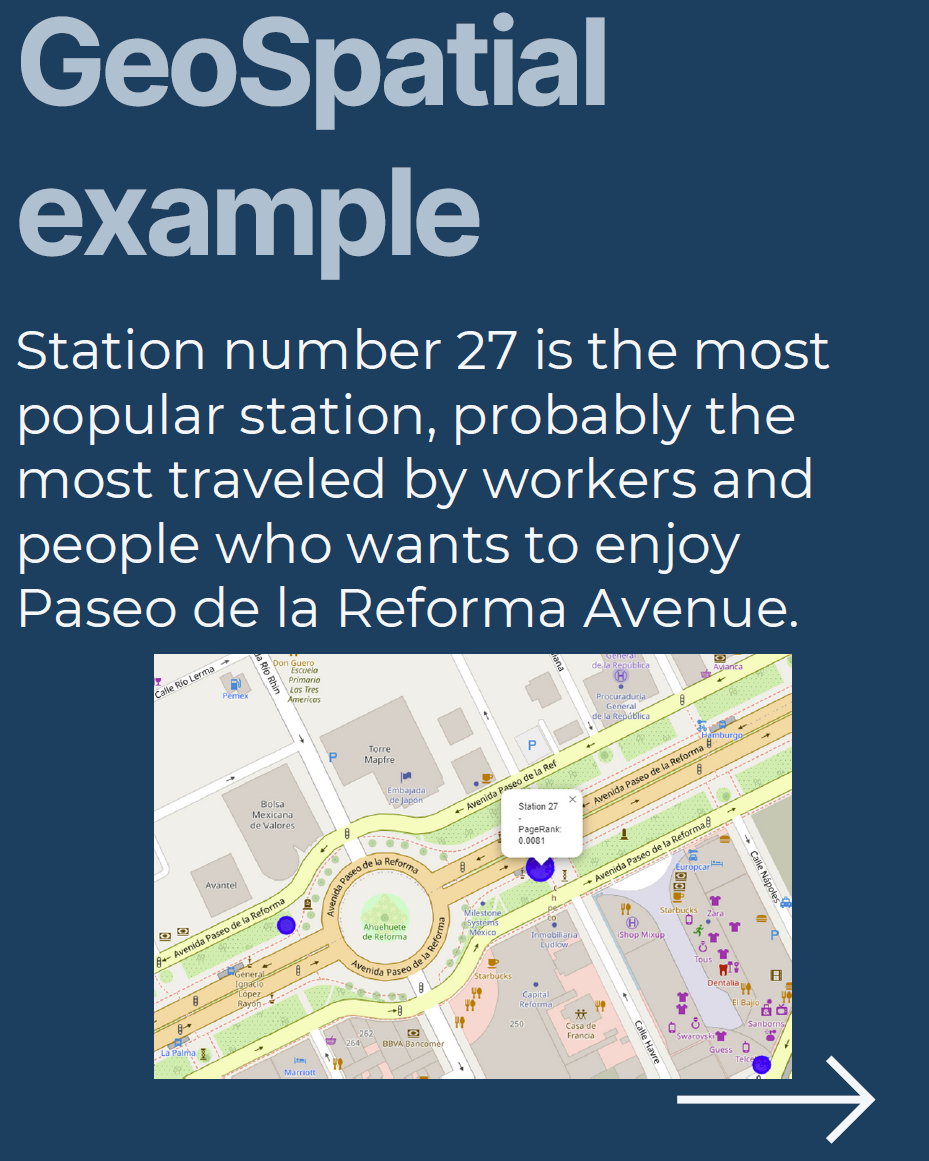